In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage, signal, interpolate, linalg
import utilities
import pyHREBSD
import rotations

%matplotlib widget

In [2]:
save_name = f"SiGeScanA"
up2 = "E:/SiGe/ScanA.up2"
pixel_size = 13.0  # The pixel size in um
Nxy = (2048, 2048)  # The number of pixels in the x and y directions on the detector
PC = utilities.convert_pc((0.5, 0.5, 0.5), Nxy, pixel_size)
# PC = (-0.0703, 0.0747, 13312.0000)
PC = (-0.0703, 0.0747, 1618.0)

# Read in data
pat_obj = utilities.read_up2(up2)
pats = utilities.get_patterns(pat_obj, (0, 50, 85))
# pats = utilities.process_patterns(pats, equalize=False, dog_sigmas=None)
# pats = utilities.process_patterns(pats, equalize=True, dog_sigmas=None)
# pats = utilities.process_patterns(pats, equalize=True, dog_sigmas=(1.0, 20.0))
pats = utilities.process_patterns(pats, equalize=False, dog_sigmas=(1.0, 20.0))

# plt.close('all')
# fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
# ax[0].imshow(pats[0], cmap='gray')
# ax[1].imshow(pats[0] - pats[1], cmap='gray')
# ax[2].imshow(pats[2], cmap='gray')
# plt.tight_layout()
# plt.show()

Reading patterns:   0%|          | 0/3 [00:00<?, ?pats/s]

Processing patterns:   0%|          | 0/1 [00:00<?, ?pats/s]

c:\Users\lambj\miniconda3\envs\hrebsd\Lib\site-packages\kornia\filters\filter.py:129: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  output = F.conv2d(input, tmp_kernel, groups=tmp_kernel.size(0), padding=0, stride=1)


In [3]:
p0 = pyHREBSD.get_initial_guess(pats[0], pats) + 0.0
print(p0)

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


In [15]:
### Functions for running HREBSD ###


def correct_geometry(H, PC, delPC) -> np.ndarray:
    """Apply projection geometry correction to a homography.

    Args:
        H (np.ndarray): The homography matrix.
        PC (np.ndarray): The pattern center.
        delPC (np.ndarray): The change in the pattern center.

    Returns:
        np.ndarray: The corrected homography."""
    x01, x02, DD = PC
    d1, d2, dDD = delPC
    alpha = (DD - dDD) / DD
    TS_inv = np.array([[1/alpha,       0, -(d1 + x01 * (alpha - 1)) / alpha],
                       [      0, 1/alpha, -(d2 + x02 * (alpha - 1)) / alpha],
                       [      0,       0,                                 1]])
    Wp = W(H)
    Wp_hat = TS_inv.dot(Wp)
    Wp_hat = Wp_hat / Wp_hat[2, 2]
    h = np.array([Wp_hat[0, 0] - 1, Wp_hat[0, 1],     Wp_hat[0, 2],
                  Wp_hat[1, 0],     Wp_hat[1, 1] - 1, Wp_hat[1, 2],
                  Wp_hat[2, 0],     Wp_hat[2, 1]])
    return h


def normalize(img) -> np.ndarray:
    """Zero-mean normalize an image with unit standard deviation.

    Args:
        img (np.ndarray): The image to normalize.

    Returns:
        np.ndarray: The normalized image."""
    # img = (img - img.min()) / (img.max() - img.min())
    img_bar = img.mean()
    dimg_tilde = img.std() * np.sqrt(img.size - 1)
    # dimg_tilde = np.sqrt(((img - img_bar)**2).sum())
    return (img - img_bar) / dimg_tilde


def jacobian(xi) -> np.ndarray:
    """Compute the jacobian of the shape function for a given subset.

    Args:
        xi (np.ndarray): The subset coordinates. Shape is (2, N).

    Returns:
        np.ndarray: The jacobian of the shape function. Shape is (2, 8, N)."""
    _1 = np.ones(xi.shape[1])
    _0 = np.zeros(xi.shape[1])
    out0 = np.array([[xi[0], xi[1],   _1,    _0,    _0,   _0,    -xi[0]**2, -xi[1]*xi[0]]])
    out1 = np.array([[   _0,    _0,   _0, xi[0], xi[1],   _1, -xi[0]*xi[1],    -xi[1]**2]])
    return np.vstack((out0, out1))


def reference_precompute(R, subset_slice, PC) -> tuple:
    """Precompute arrays/values for the reference subset for the IC-GN algorithm.

    Args:
        R (np.ndarray): The reference subset.
        subset_slice (tuple): The slice of the subset to use.

    Returns:
        np.ndarray: The subset's zero-mean normalized intensities.
        float: The zero mean standard deviation of the subset's intensities.
        np.ndarray: The subset's intensity gradients.
        np.ndarray: The subset's Hessian matrix.
        np.ndarray: The subset's coordinates."""
    # Get coordinates

    # Compute the intensity gradients of the subset
    ii = np.arange(R.shape[0]) - (R.shape[0] / 2 + PC[1])
    jj = np.arange(R.shape[1]) - (R.shape[1] / 2 + PC[0])
    II, JJ = np.meshgrid(ii, jj, indexing="ij")
    xi = np.array([II[subset_slice].flatten(), JJ[subset_slice].flatten()])

    # Compute the intensity gradients of the subset
    spline = interpolate.RectBivariateSpline(ii, jj, R, kx=5, ky=5)
    GRy = spline(xi[0], xi[1], dx=1, dy=0, grid=False)
    GRx = spline(xi[0], xi[1], dx=0, dy=1, grid=False)
    GR = np.vstack((GRx, GRy)).reshape(2, 1, -1).transpose(1, 0, 2)  # 2x1xN
    r = spline(xi[0], xi[1], grid=False).flatten()
    r_zmsv = r.std() * np.sqrt(r.size - 1)
    # r_zmsv = np.sqrt(((r - r.mean())**2).sum())
    r = (r - r.mean()) / r_zmsv

    # Get the reference intensities
    # r = spline(xi[0], xi[1], grid=False)
    # r = normalize(r)

    # Compute the jacobian of the shape function
    Jac = jacobian(xi)  # 2x8xN

    # Multiply the gradients by the jacobian
    NablaR_dot_Jac = np.einsum('ilk,ljk->ijk', GR, Jac)[0]  #1x8xN

    # Compute the Hessian
    H = 2 / r_zmsv**2 * NablaR_dot_Jac.dot(NablaR_dot_Jac.T)

    return r, r_zmsv, NablaR_dot_Jac, H, xi


def target_precompute(T: np.ndarray, PC: np.ndarray = None) -> interpolate.RectBivariateSpline:
    """Precompute arrays/values for the target subset for the IC-GN algorithm.

    Args:
        T (np.ndarray): The target subset.
        xi (np.ndarray): The subset's coordinates. Shape is (2, N). Default is None, leading to the coordinates being calculated.

    Returns:
        interpolate.RectBivariateSpline: The biquintic B-spline of the target subset."""
    # Get coordinates
    if PC is None:
        PC = np.array([0.0, 0.0])
    ii = np.arange(T.shape[0]) - (T.shape[0] / 2 + PC[1])
    jj = np.arange(T.shape[1]) - (T.shape[1] / 2 + PC[0])

    # Compute the intensity gradients of the subset
    # T_spline = interpolate.RectBivariateSpline(ii, jj, normalize(T), kx=5, ky=5)
    # T_spline = interpolate.RectBivariateSpline(ii, jj, T, kx=5, ky=5)
    T_spline = interpolate.RectBivariateSpline(ii, jj, T, kx=5, ky=5)

    return T_spline


def get_xi_prime(xi, p) -> np.ndarray:
    """Convert the subset coordinates to the deformed subset coordinates using the homography.
    The input is assumed to be in "ij" order.
    This means the coordinates are flipped to "xy" for deformation, and then flipped back to "ij" for the spline.

    Args:
        xi (np.ndarray): The subset coordinates. Shape is (2, N).
        p (np.ndarray): The homography parameters. Shape is (8,).

    Returns:
        np.ndarray: The deformed subset coordinates. Shape is (2, N)."""
    Wp = W(p)
    xi_3d = np.vstack((xi[::-1], np.ones(xi.shape[1])))
    xi_prime = Wp.dot(xi_3d)
    return (xi_prime[:2] / xi_prime[2])[::-1]


def IC_GN(p, r, T, dr_tilde, NablaR_dot_Jac, H, xi, PC, conv_tol=1e-5, max_iter=50) -> np.ndarray:
    # Precompute the target subset
    # p = p0[i]
    # T_spline = target_precompute(T[i])
    T_spline = target_precompute(T, PC)

    # Run the iterations
    num_iter = 0
    while True:
        # Warp the target subset
        num_iter += 1
        t_deformed = deform(xi, T_spline, p)
        t_deformed = normalize(t_deformed)

        # Compute the residuals
        e = r - t_deformed

        # Copmute the gradient of the correlation criterion
        dC_IC_ZNSSD = 2 / dr_tilde * np.matmul(e, NablaR_dot_Jac.T)  # 8x1

        # Find the deformation incriment, delta_p, by solving the linear system H.dot(delta_p) = -dC_IC_ZNSSD using the Cholesky decomposition
        c, lower = linalg.cho_factor(H)
        dp = linalg.cho_solve((c, lower), -dC_IC_ZNSSD.reshape(-1, 1))[:, 0]

        # Update the homography
        norm = dp_norm(dp, xi)
        Wp = W(p)
        Wp = Wp.dot(np.linalg.inv(W(dp)))
        Wp = Wp / Wp[2, 2]
        p = np.array([Wp[0, 0] - 1, Wp[0, 1], Wp[0, 2],
                        Wp[1, 0], Wp[1, 1] - 1, Wp[1, 2],
                        Wp[2, 0], Wp[2, 1]])

        # Check for convergence
        if norm < conv_tol or num_iter == max_iter:
            break
    # Take the final homography and save a 3 subplot image of the reference, the deformed target, and the residuals
    R_image = r.reshape(int(np.sqrt(r.size)), int(np.sqrt(r.size)))
    T_image = t_deformed.reshape(int(np.sqrt(t_deformed.size)), int(np.sqrt(t_deformed.size)))
    e_image = e.reshape(int(np.sqrt(e.size)), int(np.sqrt(e.size)))
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(R_image, cmap='gray')
    ax[0].set_title("Reference")
    ax[1].imshow(T_image, cmap='gray')
    ax[1].set_title("Deformed Target")
    ax[2].imshow(e_image, cmap='gray')
    ax[2].set_title("Residuals")
    plt.tight_layout()
    plt.savefig(f"IC-GN_{time.time()}.png")
    
    if num_iter == max_iter:
        print(f"Warning: Maximum number of iterations reached!")
    return p


def get_homography(R, T, subset_slice=None, conv_tol=1e-3, max_iter=50, p0=None, PC=None, parallel=True) -> np.ndarray:
    """Run the inverse compositional Gauss-Newton algorithm on a set of EBSD patterns.

    Args:
        R (np.ndarray): The reference pattern.
        T (np.ndarray): The target pattern(s). 2D (single pattern), 3D (multiple patterns), or 4D (grid of patterns) accepted.
        subset_slice (tuple): The slice of the subset to use. Default is None, which uses the entire subset.
        conv_tol (float): The convergence tolerance. Default is 1e-5.
        max_iter (int): The maximum number of iterations. Default is 50.
        p0 (np.ndarray): The initial guess for the homography parameters. Must be the same shape as T.
                         Default is None, which corresponds to zero-valued homographies.
        PC (np.ndarray): The pattern center. Default is None, which corresponds to the center of the pattern.

    Returns:
        np.ndarray: The homography parameters. Will have the same shape as T.

    TODO:
        Add pattern center correction.
        Explore multiprocessing or GPU acceleration.
    """
    # Setup the target patterns so that they are 3D
    if T.ndim == 2:
        T = T[None]  # (1, H, W)
    if p0 is not None and p0.ndim == 1:
        p0 = p0[None]

    # Check the shape of the target patterns and the initial guesses
    if p0 is not None:
        if p0.shape != T.shape[:-2] + (8,):
            raise ValueError("The initial guess must have the same shape as the target patterns.")
    else:
        p0 = np.zeros((T.shape[:-2]) + (8,), dtype=np.float32)

    # Reshape the target patterns to 3D if they are 4D
    if T.ndim == 4:
        out_shape = T.shape[:2]
        p0 = p0.reshape(T.shape[0] * T.shape[1], 8)
        T = T.reshape(T.shape[0] * T.shape[1], T.shape[2], T.shape[3])
    else:
        out_shape = T.shape[:1]

    # Set up the subset slice
    if subset_slice is None:
        subset_slice = (slice(None), slice(None))

    # Setup the pattern center
    if PC is None:
        PC = np.array([R.shape[1] / 2, R.shape[0] / 2, 0])

    # Precompute values for the reference subset
    r, dr_tilde, NablaR_dot_Jac, H, xi = reference_precompute(R, subset_slice, PC)
    p_out = np.zeros_like(p0)

    # Start loop over targets
    if parallel:
        args = [(p0[i], r, T[i], dr_tilde, NablaR_dot_Jac, H, xi, PC, conv_tol, max_iter) for i in range(T.shape[0])]
        pbar_options={'desc': 'IC-GN optimization', 'unit': 'targets'}
        with mpire.WorkerPool(n_jobs=mpire.cpu_count() // 2) as pool:
            p_out = pool.map(IC_GN, args, progress_bar=True, progress_bar_options=pbar_options)
    else:
        for i in tqdm(range(T.shape[0]), desc="IC-GN optimization", unit="targets"):
            p_out[i] = IC_GN(p0[i], r, T[i], dr_tilde, NablaR_dot_Jac, H, xi, PC, conv_tol, max_iter)

    # Reshape to match the input
    p_out = np.squeeze(p_out.reshape(out_shape + (8,)))

    # Apply a tolerance
    p_out[np.abs(p_out) < 1e-9] = 0
    return p_out


def homography_to_elastic_deformation(H, PC):
    """Calculate the deviatoric deformation gradient from a homography using the projection geometry (pattern center).
    Note that the deformation gradient is insensitive to hydrostatic dilation.
    Within the PC, the detector distance, DD (PC[2]), must be positive. The calculation requires the distance to be negative,
    as the homography is calculated from the detector to the sample. This function will negate the provided DD distance.

    Args:
        H (np.ndarray): The homography matrix.
        PC (np.ndarray): The pattern center.

    Returns:
        np.ndarray: The deviatoric deformation gradient."""
    # Reshape the homography if necessary
    if H.ndim == 1:
        H.reshape(1, 8)

    # Extract the data from the inputs 
    x01, x02, DD = PC
    h11, h12, h13, h21, h22, h23, h31, h32 = H[..., 0], H[..., 1], H[..., 2], H[..., 3], H[..., 4], H[..., 5], H[..., 6], H[..., 7]

    # Negate the detector distance becase our coordinates have +z pointing from the sample towards the detector
    # The calculation is the opposite, so we need to negate the distance
    DD = -DD

    # Calculate the deformation gradient
    beta0 = 1 - h31 * x01 - h32 * x02
    Fe11 = 1 + h11 + h31 * x01
    Fe12 = h12 + h32 * x01
    Fe13 = (h13 - h11*x01 - h12*x02 + x01*(beta0 - 1))/DD
    Fe21 = h21 + h31 * x02
    Fe22 = 1 + h22 + h32 * x02
    Fe23 = (h23 - h21*x01 - h22*x02 + x02*(beta0 - 1))/DD
    Fe31 = DD * h31
    Fe32 = DD * h32
    Fe33 = beta0
    Fe = np.array([[Fe11, Fe12, Fe13], [Fe21, Fe22, Fe23], [Fe31, Fe32, Fe33]]) / beta0

    # Reshape the output if necessary
    if Fe.ndim == 4:
        Fe = np.moveaxis(Fe, (0, 1, 2, 3), (2, 3, 0, 1))
    elif Fe.ndim == 3:
        Fe = np.squeeze(np.moveaxis(Fe, (0, 1, 2), (1, 2, 0)))

    return Fe


def deformation_to_stress_strain(Fe: np.ndarray, C: np.ndarray = None, tol: float = 1e-5) -> tuple:
    """Calculate the elastic strain tensor from the deformation gradient.
    Also calculates the lattice rotation matrix.

    Args:
        Fe (np.ndarray): The deformation gradient.
        C (np.ndarray): The stiffness tensor. If not provided, only the strain is returned
        tol (float): The tolerance for zeroing small values. Default is 1e-5.

    Returns:
        epsilon (np.ndarray): The elastic strain tensor
        omega (np.ndarray): The lattice rotation matrix
        stress (np.ndarray): The stress tensor. Only returned if the stiffness tensor is provided."""
    if Fe.ndim == 4:
        I = np.eye(3)[None, None, ...]
    elif Fe.ndim == 3:
        I = np.squeeze(np.eye(3)[None, ...])
    elif Fe.ndim == 2:
        I = np.eye(3)
    # Calculate the small strain tensor
    # Use small strain theory to decompose the deformation gradient into the elastic strain tensor and the rotation matrix
    d = Fe - I
    if Fe.ndim == 2:
        dT = d.T
    elif Fe.ndim == 3:
        dT = d.transpose(0, 2, 1)
    elif Fe.ndim == 4:
        dT = d.transpose(0, 1, 3, 2)
    epsilon = 0.5 * (d + dT)

    # Calculate the rotation tensor
    # Use the polar decomposition of the deformation gradient to decompose it into the rotation matrix and the stretch tensor
    W, S, V = np.linalg.svd(Fe, full_matrices=True)
    omega_finite = np.matmul(W, V)
    # Sigma = np.einsum('...i,ij->...ij', S, np.eye(3))
    # epsilon = np.matmul(W, np.matmul(Sigma, W.transpose(0, 1, 3, 2))) - I

    # Convert finite rotation matrix to a lattice rotation matrix
    v = rotations.om2ax(omega_finite)
    rotation_vector = v[..., :3] * v[..., 3][..., None]
    omega = np.zeros_like(omega_finite)
    omega[..., 0, 1] = -rotation_vector[..., 2]
    omega[..., 0, 2] = rotation_vector[..., 1]
    omega[..., 1, 2] = rotation_vector[..., 0]
    omega[..., 1, 0] = -omega[..., 0, 1]
    omega[..., 2, 0] = -omega[..., 0, 2]
    omega[..., 2, 1] = -omega[..., 1, 2]

    # Convert to sample frame rotation
    if Fe.ndim == 3:
        omega = np.transpose(omega, (0, 2, 1))
    elif Fe.ndim == 4:
        omega = np.transpose(omega, (0, 1, 3, 2))

    # Apply a tolerance
    epsilon[np.abs(epsilon) < tol] = 0
    omega[np.abs(omega) < tol] = 0

    if C is None:
        return epsilon, omega
    else:
        # Assume the surface normal stress is zero to get epsilon_33
        C3311Xep11 = C[0, 1] * epsilon[..., 0, 0]  #C12 * epsilon11
        C3322Xep22 = C[1, 2] * epsilon[..., 1, 1]  #C23 * epsilon22
        C3323Xep23 = C[2, 3] * epsilon[..., 1, 2]  #C34 * epsilon23
        C3331Xep31 = C[2, 4] * epsilon[..., 2, 0]  #C35 * epsilon31
        C3312Xep12 = C[0, 5] * epsilon[..., 0, 1]  #C36 * epsilon12
        epsilon[..., 2, 2] = - (C3311Xep11 + C3322Xep22 + 2*(C3323Xep23 + C3331Xep31 + C3312Xep12)) / C[2, 2]

        # Calculate the stress tensor using Hooke's law
        # Put the strain tensr in voigt notation
        epsilon_voigt = np.zeros(Fe.shape[:-2] + (6,))
        epsilon_voigt[..., 0] = epsilon[..., 0, 0]
        epsilon_voigt[..., 1] = epsilon[..., 1, 1]
        epsilon_voigt[..., 2] = epsilon[..., 2, 2]
        epsilon_voigt[..., 3] = epsilon[..., 1, 2] * 2
        epsilon_voigt[..., 4] = epsilon[..., 0, 2] * 2
        epsilon_voigt[..., 5] = epsilon[..., 0, 1] * 2
        # Calculate the stress tensor
        stress_voigt = np.einsum('...ij,...j', C, epsilon_voigt)
        stress = np.zeros(Fe.shape[:-2] + (3, 3))
        stress[..., 0, 0] = stress_voigt[..., 0]
        stress[..., 1, 1] = stress_voigt[..., 1]
        stress[..., 2, 2] = stress_voigt[..., 2]
        stress[..., 1, 2] = stress_voigt[..., 3]
        stress[..., 0, 2] = stress_voigt[..., 4]
        stress[..., 0, 1] = stress_voigt[..., 5]

        # Apply a tolerance
        stress[np.abs(stress) < tol] = 0

        return epsilon, omega, stress


### General functions for homographies ###


def W(p) -> np.ndarray:
    """Return the shape function matrix for the given homography parameters.
    Args:
        p (np.ndarray): The homography parameters.
    Returns:
        np.ndarray: The shape function matrix."""
    return np.array([[1 + p[0],     p[1], p[2]],
                     [    p[3], 1 + p[4], p[5]],
                     [    p[6],     p[7],    1]])


def dp_norm(dp, xi) -> float:
    """Compute the norm of the deformation increment.
    This is essentially a modified form of a homography magnitude.

    Args:
        dp (np.ndarray): The deformation increment. Shape is (8,).
        xi (np.ndarray): The subset coordinates. Shape is (2, N).

    Returns:
        float: The norm of the deformation increment."""
    xi1max = xi[0].max()
    xi2max = xi[1].max()
    ximax = np.array([xi1max, xi2max])
    dp_i0 = np.array([dp[0], dp[1]]) * ximax
    dp_i1 = np.array([dp[3], dp[4]]) * ximax
    dp_i2 = np.array([dp[6], dp[7]]) * ximax
    out = np.sqrt((dp_i0**2).sum() + (dp_i1**2).sum() + (dp_i2**2).sum() + (dp[2]**2 + dp[5]**2))
    return out


def shift_to_homography(x: float | np.ndarray, y: float | np.ndarray, theta: float | np.ndarray):
    """Convert a translation and rotation to a homography.

    Args:
        x (float | np.ndarray): The x-translation. Can be a scalar or an array.
        y (float | np.ndarray): The y-translation. Can be a scalar or an array.
        theta (float | np.ndarray): The rotation angle in radians. Can be a scalar or an array.

    Returns:
        np.ndarray: The homography parameters. Shape is (8,) if scalars provided. Shape is (..., 8) if arrays provided."""
    if all(isinstance(i, (int, float)) for i in (x, y, theta)):
        return np.array([np.cos(theta) - 1, -np.sin(theta), x*np.cos(theta) - y*np.sin(theta),
                         np.sin(theta), np.cos(theta) - 1, x*np.sin(theta) + y*np.cos(theta),
                         0, 0])
    else:
        _0 = np.zeros(x.shape[0])
        _c = np.cos(theta)
        _s = np.sin(theta)
        return np.array([_c - 1, -_s, x*_c-y*_s, _s, _c - 1, x*_s+y*_c, _0, _0]).T


def deform(xi: np.ndarray, spline: interpolate.RectBivariateSpline, p: np.ndarray) -> np.ndarray:
    """Deform a subset using a homography.

    Args:
        xi (np.ndarray): The subset coordinates. Shape is (2, N).
        spline (interpolate.RectBivariateSpline): The biquintic B-spline of the subset.
        p (np.ndarray): The homography parameters. Shape is (8,)."""
    xi_prime = get_xi_prime(xi, p)
    return spline(xi_prime[0], xi_prime[1], grid=False)


def deform_image(image: np.ndarray, p: np.ndarray, subset_slice: tuple = (slice(None), slice(None)), kx: int = 2, ky: int = 2) -> np.ndarray:
    """Deform an image using a homography. Creates a bicubic spline of the image, deforms the coordinates of the pixels, and interpolates the deformed coordinates using the spline to get the deformed image.
    
    Args:
        image (np.ndarray): The image to be deformed.
        p (np.ndarray): The homography parameters. has shape (8,).
        subset_slice (tuple): The slice of the image to be deformed. Default is (slice(None), slice(None)).
        kx (int): The degree of the spline in the x direction. Default is 2.
        ky (int): The degree of the spline in the y direction. Default is 2.

    Returns:
        np.ndarray: The deformed image. Same shape as the input (unless subset_slice is used)."""
    x = np.arange(image.shape[1]) - image.shape[1] / 2
    y = np.arange(image.shape[0]) - image.shape[0] / 2
    X, Y = np.meshgrid(x, y)
    xi = np.array([Y[subset_slice].flatten(), X[subset_slice].flatten()])
    spline = interpolate.RectBivariateSpline(x, y, image, kx=5, ky=5)
    xi_prime = get_xi_prime(xi, p)
    tar_rot = spline(xi_prime[0], xi_prime[1], grid=False).reshape(image.shape)
    return tar_rot




In [5]:
R = pats[0].astype(np.float64)
subset_slice = (slice(512, -512), slice(512, -512))

# Precompute values for the reference subset
r, dr_tilde, NablaR_dot_Jac, H, xi = reference_precompute(R, subset_slice, PC)

In [6]:
T = pats[2].astype(np.float64)
T_spline = target_precompute(T, PC)

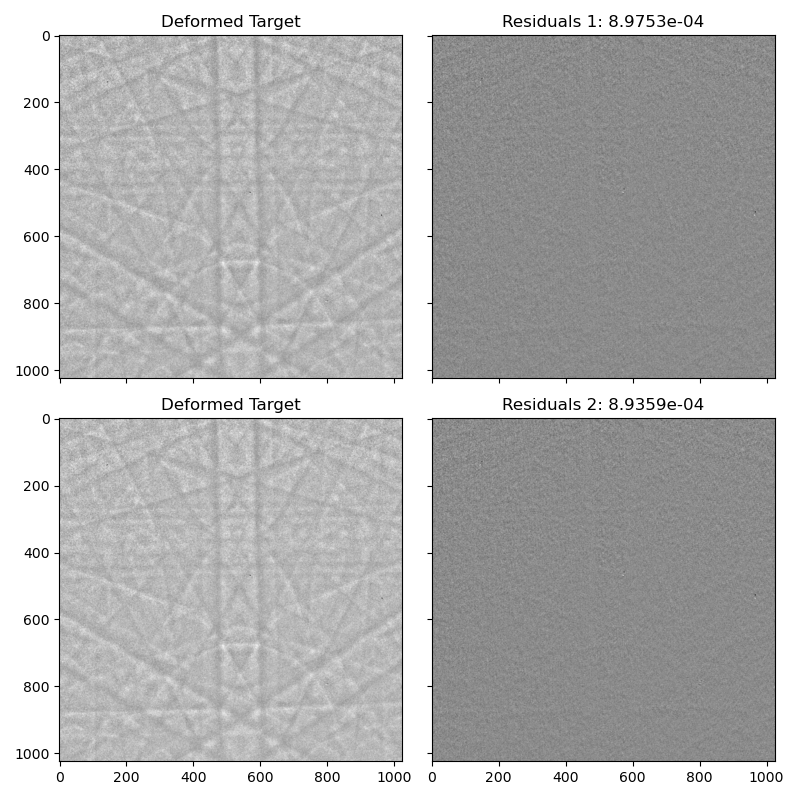

In [43]:
plt.close('all')
fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)

p = np.array([-0.002, 0.0, 3.0, 0.0, -0.001, -10.0, 0.0, 0.0])
t_deformed = deform(xi, T_spline, p)
t_deformed = normalize(t_deformed)
e1 = (r - t_deformed).reshape(R[subset_slice].shape)
ax[0, 0].imshow(t_deformed.reshape(R[subset_slice].shape), cmap='gray')
ax[0, 0].set_title("Deformed Target")
ax[0, 1].imshow(e1, cmap='gray')
ax[0, 1].set_title("Residuals 1: " + f"{np.abs(e1).mean():.4e}")

p = np.array([-0.005, 0.0, 3.0, 0.0, -0.001, -10.0, 0.0, 0.0])
t_deformed = deform(xi, T_spline, p)
t_deformed = normalize(t_deformed)
e2 = (r - t_deformed).reshape(R[subset_slice].shape)
ax[1, 0].imshow(t_deformed.reshape(R[subset_slice].shape), cmap='gray')
ax[1, 0].set_title("Deformed Target")
ax[1, 1].imshow(e2, cmap='gray', vmin=e1.min(), vmax=e1.max())
ax[1, 1].set_title("Residuals 2: " + f"{np.abs(e2).mean():.4e}")

plt.tight_layout()
plt.show()


In [44]:
T = pats[2].astype(np.float64)

conv_tol = 1e-2
max_iter = 100

# p = p0[1].copy()
p = np.array([-0.005, 0.0, 3.0, 0.0, -0.001, -10.0, 0.0, 0.0])
# p = np.array([0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# Precompute the target subset
T_spline = target_precompute(T, PC)

# Run the iterations
num_iter = 0
pnorms = []
residuals = []
while True:
    # Warp the target subset
    num_iter += 1
    t_deformed = deform(xi, T_spline, p)
    t_deformed = normalize(t_deformed)

    # Compute the residuals
    e = r - t_deformed
    residuals.append(np.abs(e).mean())

    # Copmute the gradient of the correlation criterion
    dC_IC_ZNSSD = 2 / dr_tilde * np.matmul(e, NablaR_dot_Jac.T)  # 8x1

    # Find the deformation incriment, delta_p, by solving the linear system H.dot(delta_p) = -dC_IC_ZNSSD using the Cholesky decomposition
    c, lower = linalg.cho_factor(H)
    dp = linalg.cho_solve((c, lower), -dC_IC_ZNSSD.reshape(-1, 1))[:, 0]
    # Do it the slow way
    # dp = np.linalg.solve(H, -dC_IC_ZNSSD)

    # Update the homography
    norm = dp_norm(dp, xi)
    Wp = W(p)
    Wp = Wp.dot(np.linalg.inv(W(dp)))
    Wp = Wp / Wp[2, 2]
    p = np.array([Wp[0, 0] - 1, Wp[0, 1], Wp[0, 2],
                  Wp[1, 0], Wp[1, 1] - 1, Wp[1, 2],
                  Wp[2, 0], Wp[2, 1]])

    # Save out the images for debugging
    R_image = r.reshape(int(np.sqrt(r.size)), int(np.sqrt(r.size)))
    T_image = t_deformed.reshape(int(np.sqrt(t_deformed.size)), int(np.sqrt(t_deformed.size)))
    e_image = e.reshape(int(np.sqrt(e.size)), int(np.sqrt(e.size)))
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(R_image, cmap='gray')
    ax[0].set_title("Reference")
    ax[1].imshow(T_image, cmap='gray')
    ax[1].set_title("Deformed Target")
    im = ax[2].imshow(e_image, cmap='gray')
    ax[2].set_title("Residuals")
    cax = plt.axes([0.92, 0.1, 0.01, 0.2])
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    plt.savefig(f"gif/{num_iter}.png")
    plt.close(fig)
    pnorms.append(norm)
    print(f"Iteration {num_iter}: Norm = {norm:.2e}", "\n\tp: ({:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f})".format(*p), "dp: ({:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f},{:.5f})".format(*dp))
                        
    # Check for convergence
    if norm < conv_tol or num_iter == max_iter:
        break

if num_iter == max_iter:
    print(f"Warning: Maximum number of iterations reached!")

C:\Users\lambj\AppData\Local\Temp\ipykernel_43088\894501430.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Iteration 1: Norm = 2.19e-02 
	p: (-0.00499,-0.00003,3.00042,-0.00003,-0.00099,-9.99139,-0.00000,0.00000) dp: (-0.00001,0.00003,-0.00042,0.00003,-0.00001,-0.00862,0.00000,-0.00000)
Iteration 2: Norm = 2.21e-02 
	p: (-0.00499,-0.00006,3.00085,-0.00005,-0.00098,-9.98292,-0.00000,0.00000) dp: (-0.00001,0.00003,-0.00043,0.00003,-0.00001,-0.00848,0.00000,-0.00000)
Iteration 3: Norm = 2.22e-02 
	p: (-0.00498,-0.00008,3.00129,-0.00008,-0.00097,-9.97458,-0.00000,0.00000) dp: (-0.00001,0.00003,-0.00045,0.00003,-0.00001,-0.00834,0.00000,-0.00000)
Iteration 4: Norm = 2.24e-02 
	p: (-0.00497,-0.00011,3.00176,-0.00010,-0.00096,-9.96638,-0.00000,0.00000) dp: (-0.00001,0.00003,-0.00046,0.00003,-0.00001,-0.00821,0.00000,-0.00000)
Iteration 5: Norm = 2.25e-02 
	p: (-0.00497,-0.00014,3.00223,-0.00013,-0.00095,-9.95832,-0.00000,0.00000) dp: (-0.00001,0.00003,-0.00048,0.00003,-0.00001,-0.00807,0.00000,-0.00000)
Iteration 6: Norm = 2.27e-02 
	p: (-0.00496,-0.00017,3.00273,-0.00016,-0.00094,-9.95039,-0.0000

KeyboardInterrupt: 

[[-0.00440128 -0.00177004 -0.00083292]
 [-0.00177004  0.          0.00314683]
 [-0.00083292  0.00314683  0.        ]]


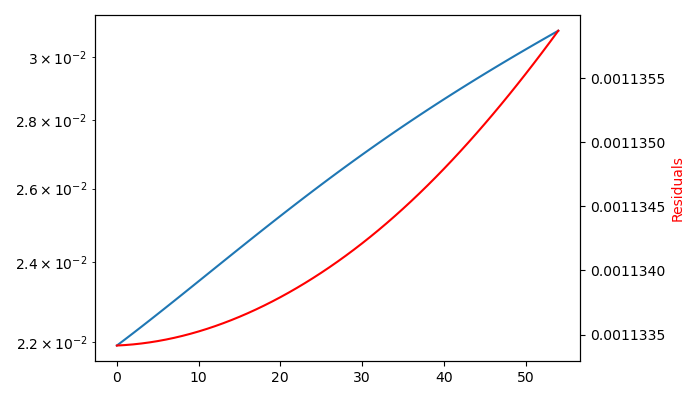

In [45]:
p[np.abs(p) < 1e-9] = 0
print(deformation_to_stress_strain(homography_to_elastic_deformation(p, PC), tol=1e-4)[0])

plt.close("all")
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
axt = ax.twinx()
ax.plot(pnorms)
axt.plot(residuals, color='red')
ax.set_yscale('log')
axt.set_ylabel('Residuals', color='red')
plt.tight_layout()
plt.show()


In [ ]:
def calc_strain(reference_pattern, target_pattern, pattern_center, p, subset_slice):
    r, dr_tilde, NablaR_dot_Jac, H, xi = reference_precompute(reference_pattern, subset_slice, pattern_center)
    T_spline = target_precompute(target_pattern, pattern_center)
        
    num_iter = 0
    pnorms = []
    residuals = []
    while True:
        # Warp the target subset
        num_iter += 1
        t_deformed = deform(xi, T_spline, p)
        t_deformed = normalize(t_deformed)

        # Compute the residuals
        e = r - t_deformed
        residuals.append(np.abs(e).mean())

        # Copmute the gradient of the correlation criterion
        dC_IC_ZNSSD = 2 / dr_tilde * np.matmul(e, NablaR_dot_Jac.T)  # 8x1

        # Find the deformation incriment, delta_p, by solving the linear system H.dot(delta_p) = -dC_IC_ZNSSD using the Cholesky decomposition
        c, lower = linalg.cho_factor(H)
        dp = linalg.cho_solve((c, lower), -dC_IC_ZNSSD.reshape(-1, 1))[:, 0]

        # Update the homography
        norm = dp_norm(dp, xi)
        Wp = W(p)
        Wp = Wp.dot(np.linalg.inv(W(dp)))
        Wp = Wp / Wp[2, 2]
        p = np.array([Wp[0, 0] - 1, Wp[0, 1], Wp[0, 2],
                    Wp[1, 0], Wp[1, 1] - 1, Wp[1, 2],
                    Wp[2, 0], Wp[2, 1]])

        # Check for convergence
        if norm < conv_tol or num_iter == max_iter:
            break

    if num_iter == max_iter:
        print(f"Warning: Maximum number of iterations reached!")

    strain = deformation_to_stress_strain(homography_to_elastic_deformation(p, pattern_center))[0]
    return calculate_von_mises_strain(strain)


def calculate_von_mises_strain(strain_tensor):
    # Extract strain components
    eps_xx, eps_yy, eps_zz = np.diag(strain_tensor)
    eps_xy, eps_yz, eps_zx = strain_tensor[0, 1], strain_tensor[1, 2], strain_tensor[2, 0]

    # Calculate hydrostatic strain
    hydrostatic_strain = (eps_xx + eps_yy + eps_zz) / 3

    # Calculate deviatoric strain tensor
    deviatoric_strain = strain_tensor - hydrostatic_strain * np.eye(3)

    # Calculate second invariant of deviatoric strain tensor
    J2 = 0.5 * (deviatoric_strain[0, 0]**2 + deviatoric_strain[1, 1]**2 + deviatoric_strain[2, 2]**2) + \
         deviatoric_strain[0, 1]**2 + deviatoric_strain[1, 2]**2 + deviatoric_strain[2, 0]**2

    # Calculate von Mises equivalent strain
    von_mises_strain = np.sqrt(2/3 * J2)

    return von_mises_strain


def monte_carlo_optimization(reference_pattern, target_pattern, initial_center, num_iterations, step_size, p0, subset_slice):
    best_center = initial_center
    best_strain = calc_strain(reference_pattern, target_pattern, best_center, p0, subset_slice)

    current_center = best_center
    current_strain = best_strain

    for i in range(num_iterations):
        # Generate a new candidate center by adding random perturbations to the current center
        candidate_center = current_center + np.around(np.random.uniform(-step_size, step_size, size=len(current_center)), 4)
        candidate_center[2] = initial_center[2]

        # Calculate the strain using the candidate center
        candidate_strain = calc_strain(reference_pattern, target_pattern, candidate_center, p0, subset_slice)

        # Accept the candidate center if it improves the strain
        if candidate_strain < current_strain:
            current_center = candidate_center
            current_strain = candidate_strain

        # Update the best center if the current strain is better than the best strain
        if current_strain < best_strain:
            best_center = current_center
            best_strain = current_strain

        # Print the progress every 100 iterations
        print(f"Iteration {i + 1}: Best Strain = {best_strain}")

    return best_center, best_strain


best_pc, best_strain = monte_carlo_optimization(pats[0], pats[2], PC, 25, 0.02, p0[2], (slice(512, 1536), slice(512, 1536)))
print("Original Pattern Center: ({},{},{})".format(PC[0], PC[1], PC[2]))
print("Best Pattern Center: ({:.4f},{:.4f},{:.4f})".format(best_pc[0], best_pc[1], best_pc[2]))
print(f"Best Von Mises Strain: {best_strain}")

In [ ]:
print(PC)

In [ ]:
R = pats[0]
subset_slice = (slice(512, -512), slice(512, -512))

ii = np.arange(R.shape[0]) - (R.shape[0] / 2 + PC[1])
jj = np.arange(R.shape[1]) - (R.shape[1] / 2 + PC[0])
II, JJ = np.meshgrid(ii, jj, indexing="ij")
xi = np.array([II[subset_slice].flatten(), JJ[subset_slice].flatten()])

# Compute the intensity gradients of the subset
spline = interpolate.RectBivariateSpline(ii, jj, R, kx=5, ky=5)
r = spline(xi[0], xi[1], grid=False).reshape(R[subset_slice].shape)

r_d1 = deform(xi, spline, np.array([0.0, 0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0])).reshape(R[subset_slice].shape)
r_d2 = deform(xi, spline, np.array([0.0, 0.0, 0.0, 0.0, 0.0, 100.0, 0.0, 0.0])).reshape(R[subset_slice].shape)

plt.close('all')
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
ax = ax.flatten()
ax[0].imshow(R, cmap='gray')
ax[0].grid()
ax[1].imshow(r, cmap='gray')
ax[1].grid()
ax[2].imshow(r_d1, cmap='gray')
ax[2].grid()
ax[2].set_title("Deformed Target1")
ax[3].imshow(r_d2, cmap='gray')
ax[3].grid()
ax[3].set_title("Deformed Target2")
ax[4].imshow(xi[0].reshape(R[subset_slice].shape), cmap='gray')
ax[5].imshow(xi[1].reshape(R[subset_slice].shape), cmap='gray')
plt.tight_layout()
plt.show()
